# Predict Future Sales EDA

###  Data Description from Kaggle
You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

### File descriptions
**sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.  
**test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.  
sample_submission.csv - a sample submission file in the correct format.  
**items.csv** - supplemental information about the items/products.  
**item_categories.csv**  - supplemental information about the items categories.  
**shops.csv** - supplemental information about the shops.  
### Data fields
**ID** - an Id that represents a (Shop, Item) tuple within the test set  
**shop_id** - unique identifier of a shop  
**item_id** - unique identifier of a product  
**item_category_id** - unique identifier of item category  
**item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure  
**item_price** - current price of an item  
**date** - date in format dd/mm/yyyy  
**date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33  
**item_name** - name of item  
**shop_name** - name of shop  
**item_category_name** - name of item category  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
import itertools
import gc
import pickle

%matplotlib inline

## Load Data

In [2]:
df_train = pd.read_csv('data/sales_train_v2.csv')
df_test = pd.read_csv('data/test.csv')
df_items = pd.read_csv('data/items.csv')
df_item_categories = pd.read_csv('data/item_categories.csv')
df_shops = pd.read_csv('data/shops.csv')

In [3]:
df_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [4]:
df_train.tail(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [5]:
df_test.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [6]:
df_items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [7]:
df_shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


## Preliminary Wrangling

### 중복 체크

In [9]:
sum(df_train.duplicated()), sum(df_test.duplicated())

(6, 0)

In [10]:
sum(df_items.duplicated()), sum(df_item_categories.duplicated()), sum(df_shops.duplicated())

(0, 0, 0)

df_train에만 중복 행이 6개 있음

In [11]:
df_train[df_train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [12]:
# 중복 제거
df_train.drop_duplicates(inplace=True)

In [13]:
# 중복 재확인
sum(df_train.duplicated())

0

### Null 체크

In [14]:
df_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [15]:
df_test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

훈련 데이터, 테스트 데이터에 Null값은 없음

### Outlier 제거

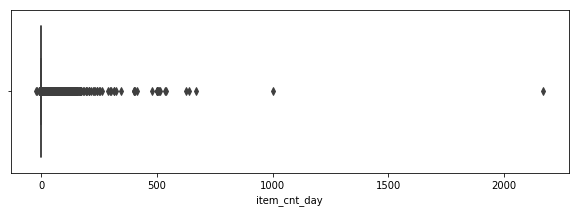

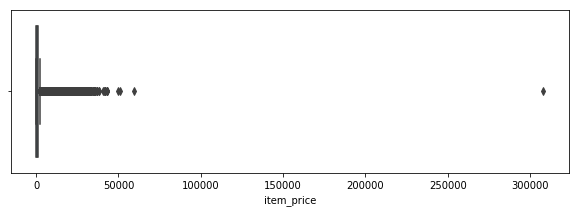

In [16]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=df_train);

item_cnt_day 500이상, item_price 50,000 이상의 Outlier 제거

In [17]:
df_train = df_train[df_train.item_cnt_day < 500]
df_train = df_train[df_train.item_price < 50000]

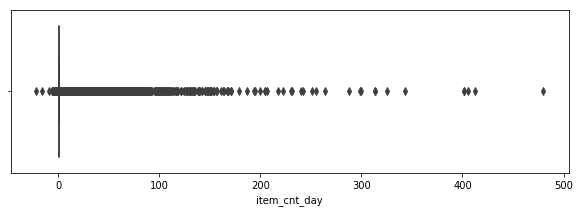

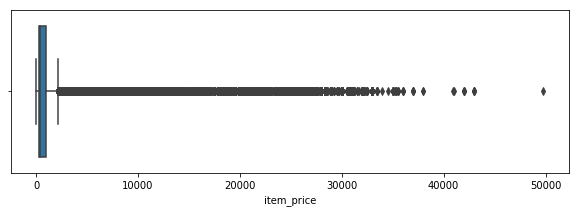

In [18]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=df_train);

In [19]:
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935826e+06,2.935826e+06,2.935826e+06,2.935826e+06,2.935826e+06
mean,1.456986e+01,3.300178e+01,1.019721e+04,8.907121e+02,1.239344e+00
std,9.422973e+00,1.622696e+01,6.324294e+03,1.719911e+03,1.923299e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,4.978200e+04,4.800000e+02


item_pirce와 item_cnt_day가 0 미만인 수 제거

In [20]:
df_train = df_train[df_train.item_cnt_day >= 0]
df_train = df_train[df_train.item_price >= 0]

### Shops name 수정

In [21]:
df_shops.head(2)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [22]:
df_shops.loc[df_shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [23]:
 df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])

In [24]:
df_shops.head(2)

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск


In [25]:
df_shops.loc[df_shops.city == '!Якутск', 'city'] = 'Якутск'

수치 데이터가 아닌 문자 데이터는 데이터 분석이 번거롭다. 따라서 문자 데이터를 모두 수치 데이터로 Encoding하는 작업이 필요하다.

### df_shops Enconding

In [26]:
df_shops.city.value_counts()

Москва              13
Якутск               4
Воронеж              3
Тюмень               3
РостовНаДону         3
СПб                  2
Красноярск           2
Жуковский            2
Самара               2
Н.Новгород           2
Казань               2
Уфа                  2
Новосибирск          2
Томск                1
СергиевПосад         1
Омск                 1
Химки                1
Сургут               1
Мытищи               1
Калуга               1
Волжский             1
Адыгея               1
Вологда              1
Коломна              1
Выездная             1
Ярославль            1
Интернет-магазин     1
Цифровой             1
Чехов                1
Балашиха             1
Курск                1
Name: city, dtype: int64

In [27]:
city_encoder = LabelEncoder()
df_shops['city_code'] = city_encoder.fit_transform(df_shops['city'])
df_shops = df_shops[['shop_id', 'city_code']]
df_shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


### Item category Encoding

In [28]:
df_item_categories.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [29]:
type_encoder = LabelEncoder()
df_item_categories['split_name'] = df_item_categories['item_category_name'].str.split(' - ')
df_item_categories['type'] = df_item_categories['split_name'].map(lambda x: x[0].strip())
df_item_categories['type_code'] = type_encoder.fit_transform(df_item_categories['type'])

In [30]:
df_item_categories.head(2)

,item_category_name,item_category_id,split_name,type,type_code
0,PC - Гарнитуры/Наушники,0,"[PC, Гарнитуры/Наушники]",PC,0
1,Аксессуары - PS2,1,"[Аксессуары, PS2]",Аксессуары,1


In [31]:
subtype_encoder = LabelEncoder()
df_item_categories['subtype'] = df_item_categories['split_name'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_item_categories['subtype_code'] = subtype_encoder.fit_transform(df_item_categories['subtype'])
df_item_categories = df_item_categories[['item_category_id', 'type_code', 'subtype_code']]

In [32]:
df_item_categories.head(2)

,item_category_id,type_code,subtype_code
0,0,0,31
1,1,1,11


### Item Encoding
이미 item_id와 item_category_id가 숫자로 매핑되어 있어 name만 drop해주면 됨

In [33]:
df_items.drop(['item_name'], axis=1, inplace=True)

In [34]:
df_items.head(2)

,item_id,item_category_id
0,0,40
1,1,76


Encoding된 shops, category, item

In [35]:
df_shops.head(2)

,shop_id,city_code
0,0,29
1,1,29


In [36]:
df_item_categories.head(2)

,item_category_id,type_code,subtype_code
0,0,0,31
1,1,1,11


In [37]:
df_items.head(2)

,item_id,item_category_id
0,0,40
1,1,76


### df_test shop_id, item_id

In [38]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [39]:
df_test.shop_id.value_counts()

59    5100
16    5100
28    5100
26    5100
25    5100
24    5100
22    5100
21    5100
19    5100
18    5100
15    5100
58    5100
14    5100
12    5100
10    5100
7     5100
6     5100
5     5100
4     5100
3     5100
31    5100
34    5100
35    5100
36    5100
57    5100
56    5100
55    5100
53    5100
52    5100
50    5100
49    5100
48    5100
47    5100
46    5100
45    5100
44    5100
42    5100
41    5100
39    5100
38    5100
37    5100
2     5100
Name: shop_id, dtype: int64

In [40]:
len(df_test.shop_id.unique())

42

총 42개의 shop_id가 있으며 각 shop_id마다 5,100개의 item이 있다.

In [41]:
len(set(df_test.item_id) - set(df_train.item_id))

363

df_test에는 있지만 df_train에는 없는 item_id가 총 363개 있다. 이는 df_train에 모든 종류의 item이 있지는 않다는 것을 뜻한다. 363개의 item에 대해서는 0개가 판매된 것으로 예측해야한다.

In [42]:
len(df_test) == 42*5100

True

42개의 shop_id, 5,100개의 item이 있으므로 df_test에는 총 42*5100 = 214,200개의 row가 있다

### 'date_block_num', 'shop_id', 'item_id'로 구성된 Matrix 만들기

In [43]:
num_date_block_num = len(df_train.date_block_num.value_counts())
num_date_block_num

34

In [44]:
ts = time.time()
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = df_train[df_train.date_block_num == i]
    matrix.append(np.array(list(itertools.product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
# int8 -> Byte (-128 to 127), int16 -> Integer (-32768 to 32767)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)
time.time()-ts

23.73551630973816

In [45]:
matrix.head()

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32


위 for loop안의 itertools.product 부분이 이해가 안 간다면 아래 참고!

In [46]:
sales = df_train[df_train.date_block_num == 1]

In [47]:
sales.shop_id.unique()

array([50, 47, 51, 52, 42, 46, 43, 54, 56, 59,  7, 53, 16, 18, 19, 14, 15,
       13, 23, 24, 21, 25, 22,  4,  3,  5,  1,  2,  6,  0,  8, 12, 10, 31,
       32, 35, 44, 41, 45, 37, 38, 26, 27, 29, 30, 28], dtype=int64)

In [48]:
sales.item_id.unique()

array([ 3880,  4128,  4124, ..., 12885, 12791, 13433], dtype=int64)

In [49]:
list(itertools.product([1], sales.shop_id.unique(), sales.item_id.unique()))

[(1, 50, 3880),
 (1, 50, 4128),
 (1, 50, 4124),
 (1, 50, 3879),
 (1, 50, 3885),
 (1, 50, 3950),
 (1, 50, 4163),
 (1, 50, 3897),
 (1, 50, 3941),
 (1, 50, 3959),
 (1, 50, 4036),
 (1, 50, 3983),
 (1, 50, 3993),
 (1, 50, 4127),
 (1, 50, 3890),
 (1, 50, 4115),
 (1, 50, 3878),
 (1, 50, 3834),
 (1, 50, 3850),
 (1, 50, 3851),
 (1, 50, 3788),
 (1, 50, 3805),
 (1, 50, 3869),
 (1, 50, 3870),
 (1, 50, 3871),
 (1, 50, 4164),
 (1, 50, 4244),
 (1, 50, 4245),
 (1, 50, 4248),
 (1, 50, 4249),
 (1, 50, 4251),
 (1, 50, 4266),
 (1, 50, 4092),
 (1, 50, 4282),
 (1, 50, 4241),
 (1, 50, 4227),
 (1, 50, 4240),
 (1, 50, 3508),
 (1, 50, 3328),
 (1, 50, 3321),
 (1, 50, 3322),
 (1, 50, 3360),
 (1, 50, 3362),
 (1, 50, 3366),
 (1, 50, 3367),
 (1, 50, 3320),
 (1, 50, 3325),
 (1, 50, 3326),
 (1, 50, 3327),
 (1, 50, 3476),
 (1, 50, 3702),
 (1, 50, 3705),
 (1, 50, 3718),
 (1, 50, 3698),
 (1, 50, 3719),
 (1, 50, 3743),
 (1, 50, 3745),
 (1, 50, 3622),
 (1, 50, 3624),
 (1, 50, 3693),
 (1, 50, 3490),
 (1, 50, 3371),
 (1, 50,

### df_train의 Groupby를 통한 Monthly Sales 구하기
df_train에 revenue를 추가한다

In [50]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0


In [51]:
df_train['revenue'] = df_train['item_price'] * df_train['item_cnt_day']

In [52]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,349.00


df_train의 Groupby

In [53]:
group = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})

Groupby.agg Reference: https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html

In [54]:
group.head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              0       32               6.0
                       33               3.0
                       35               1.0
                       43               1.0
                       51               2.0

In [55]:
group.columns = ['item_cnt_month']

In [56]:
group.head()

item_cnt_month
date_block_num shop_id item_id                
0              0       32                  6.0
                       33                  3.0
                       35                  1.0
                       43                  1.0
                       51                  2.0

In [57]:
group.reset_index(inplace=True)

reset_index reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html

In [58]:
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


marix와 group을 merge한다

In [59]:
matrix.head()

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32


In [60]:
matrix = pd.merge(matrix, group, how='left')

In [61]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,NaN
1,0,0,27,NaN
2,0,0,28,NaN
3,0,0,29,NaN
4,0,0,32,6.0


In [62]:
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0, 30).astype(np.float16))

NaN은 0으로 바꾸고, 범위를 0과 30사이로 정한다. 30이 넘어가는 수는 그다지 많지 않기 때문에 예측의 정확성을 위해 범위를 지정해준다. 타입도 float16으로 바꾼다.

In [63]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


이제 matrx에는 모든 date_block_num, shop_id, tiem_id에 따른 월별 판매량이 저장되어 있다.

### Matrix에 테스트 데이터 붙이기

In [64]:
df_test.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [65]:
df_test['date_block_num'] = 34
df_test['date_block_num'] = df_test['date_block_num'].astype(np.int8)
df_test['shop_id'] = df_test['shop_id'].astype(np.int8)
df_test['item_id'] = df_test['item_id'].astype(np.int16)

In [66]:
df_test.head(2)

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34


In [67]:
matrix = pd.concat([matrix, df_test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # for 34 month
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID
0,0,0,19,0.0,0.0
1,0,0,27,0.0,0.0
2,0,0,28,0.0,0.0
3,0,0,29,0.0,0.0
4,0,0,32,6.0,0.0


### matrix에 df_shops, df_items, df_item_categories merge하기
겹치는 column을 기준으로 df_shops, df_items, df_item_categories를 matrix에 merge시킨다

In [68]:
matrix = pd.merge(matrix, df_shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, df_items, on=['item_id'], how='left')
matrix = pd.merge(matrix, df_item_categories, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [69]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code
0,0,0,19,0.0,0.0,29,40,11,6
1,0,0,27,0.0,0.0,29,19,5,12
2,0,0,28,0.0,0.0,29,30,8,57
3,0,0,29,0.0,0.0,29,23,5,18
4,0,0,32,6.0,0.0,29,40,11,6


In [70]:
matrix[matrix['date_block_num'] == 0]

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code
0,0,0,19,0.0,0.0,29,40,11,6
1,0,0,27,0.0,0.0,29,19,5,12
2,0,0,28,0.0,0.0,29,30,8,57
3,0,0,29,0.0,0.0,29,23,5,18
4,0,0,32,6.0,0.0,29,40,11,6
5,0,0,33,3.0,0.0,29,37,11,1
6,0,0,34,0.0,0.0,29,40,11,6
7,0,0,35,1.0,0.0,29,40,11,6
8,0,0,40,0.0,0.0,29,57,13,10
9,0,0,41,0.0,0.0,29,57,13,10


### Matrix에 Target lags 추가
item_cnt_month_i는 i달 전의 동일 shop, 동일 제품의 판매량을 말한다.

In [71]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [72]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

### Mean encoded features

In [73]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']

In [74]:
group.head()

,date_avg_item_cnt
date_block_num,
0,0.354980
1,0.333008
2,0.367432
3,0.287354
4,0.270996


In [75]:
group.reset_index(inplace=True)

In [76]:
group.head()

,date_block_num,date_avg_item_cnt
0,0,0.354980
1,1,0.333008
2,2,0.367432
3,3,0.287354
4,4,0.270996


matrix에 월 평균 판매 수량 (date_avg_item_cnt) 추가하기

In [77]:
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt
0,0,0,19,0.0,0.0,29,40,11,6,NaN,NaN,NaN,NaN,NaN,0.35498
1,0,0,27,0.0,0.0,29,19,5,12,NaN,NaN,NaN,NaN,NaN,0.35498
2,0,0,28,0.0,0.0,29,30,8,57,NaN,NaN,NaN,NaN,NaN,0.35498
3,0,0,29,0.0,0.0,29,23,5,18,NaN,NaN,NaN,NaN,NaN,0.35498
4,0,0,32,6.0,0.0,29,40,11,6,NaN,NaN,NaN,NaN,NaN,0.35498


matrix에 월 평균 판매 수량에 대한 1달 lag 추가하기

In [78]:
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')

In [79]:
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt,date_avg_item_cnt_lag_1
11098655,34,45,18454,0.0,214195.0,20,55,13,4,1.0,0.0,0.0,0.0,NaN,0.0,0.266846
11098656,34,45,16188,0.0,214196.0,20,64,14,44,0.0,0.0,NaN,NaN,NaN,0.0,0.266846
11098657,34,45,15757,0.0,214197.0,20,55,13,4,0.0,0.0,0.0,0.0,0.0,0.0,0.266846
11098658,34,45,19648,0.0,214198.0,20,40,11,6,0.0,0.0,0.0,0.0,NaN,0.0,0.266846
11098659,34,45,969,0.0,214199.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.266846


In [80]:
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
11098655,34,45,18454,0.0,214195.0,20,55,13,4,1.0,0.0,0.0,0.0,NaN,0.266846
11098656,34,45,16188,0.0,214196.0,20,64,14,44,0.0,0.0,NaN,NaN,NaN,0.266846
11098657,34,45,15757,0.0,214197.0,20,55,13,4,0.0,0.0,0.0,0.0,0.0,0.266846
11098658,34,45,19648,0.0,214198.0,20,40,11,6,0.0,0.0,0.0,0.0,NaN,0.266846
11098659,34,45,969,0.0,214199.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0,0.266846


matrix에 월별 item별 평균 판매 수량(date_item_avg_item_cnt) 추가하기

In [81]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 category별 평균 판매 수량(date_cat_avg_item_cnt) 추가하기

In [82]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 shop별, category별 평균 판매 수량(date_shop_cat_avg_item_cnt) 추가하기

In [83]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 shop별, type_code별 평균 판매 수량(date_shop_type_avg_item_cnt) 추가하기

In [84]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 shop별, subtype_code별 평균 판매 수량(date_shop_subtype_avg_item_cnt) 추가하기

In [85]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 city_code별 평균 판매 수량(date_city_avg_item_cnt) 추가하기

In [86]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 item별, city_code별 평균 판매 수량(date_item_city_avg_item_cnt) 추가하기

In [87]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 type_code별 평균 판매 수량(date_type_avg_item_cnt) 추가하기

In [88]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 subtype_code별 평균 판매 수량(date_subtype_avg_item_cnt) 추가하기

In [89]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

### Trend Features
지난 6개월 간의 가격 변동폭을 살펴본다

In [90]:
group = df_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

In [91]:
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = df_train.groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1, 2, 3, 4, 5, 6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

In [92]:
for lag in lags:
    matrix['delta_price_lag_'+str(lag)] = \
    (matrix['date_item_avg_item_price_lag_'+str(lag)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for lag in lags:
        if row['delta_price_lag_'+str(lag)]:
            return row['delta_price_lag_'+str(lag)]
    return 0

In [93]:
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

delta_price_lag를 구했으므로 필요없는 feature는 drop

In [95]:
features_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    features_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    features_to_drop += ['delta_price_lag_'+str(i)]

In [96]:
matrix.drop(features_to_drop, axis=1, inplace=True)

지난달 shop revenue trend를 살펴본다

In [97]:
group = df_train.groupby(['date_block_num', 'shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

In [98]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

In [99]:
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

In [100]:
matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

In [101]:
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

In [102]:
matrix = lag_feature(matrix, [1], 'delta_revenue')

In [103]:
matrix.drop(['date_shop_revenue', 'shop_avg_revenue', 'delta_revenue'], axis=1, inplace=True)

### Special Features

date_block_num를 기반으로 month를 도출한다

In [104]:
matrix['month'] = matrix['date_block_num'] % 12

월별 일수를 matrix에 추가한다

In [106]:
days = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [108]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days
0,0,0,19,0.0,0.0,29,40,11,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
1,0,0,27,0.0,0.0,29,19,5,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
2,0,0,28,0.0,0.0,29,30,8,57,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
3,0,0,29,0.0,0.0,29,23,5,18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
4,0,0,32,6.0,0.0,29,40,11,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31


마지막 판매가 있고 나서부터 지난 개월 수 (shop-item pair별, item별)

In [109]:
# shop-item pari별
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)

for index, row in matrix.iterrows():
    key = str(row.item_id) + ' ' + str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[index, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num

In [ ]:
# item pari별
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)

for index, row in matrix.iterrows():
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[index, 'item_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num

첫번째 판매 후 지난 개월 수 (shop-item pair, item pair 별)

In [ ]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')

In [ ]:
matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num']

In [ ]:
matrix.groupby(['item_id','shop_id'])['date_block_num']

### Final preparations

lag를 12까지 사용했으므로 첫 12달은 drop한다

In [ ]:
matrix = matrix[matrix.date_block_num > 11]

In [ ]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
    return df

matrix = fill_na(matrix)

In [ ]:
matrix.columns

In [ ]:
matrix.info()

In [ ]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del df_items
del df_shops
del df_item_categories
del df_train
gc.collect();


### Part 2, xgboost

In [ ]:
data = pd.read_pickle('data.pkl')

In [ ]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [ ]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
del data
gc.collect();

In [ ]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

In [ ]:
submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))